In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# from google.colab import drive
# import os
# drive.mount('/content/gdrive/')

In [4]:
import numpy as np
from keras.utils import get_file
import matplotlib.pyplot as plt

#style_transfer_url = "https://i.imgur.com/9ooB60I.jpg"
#base_url = "https://tourism.euskadi.eus/contenidos/d_destinos_turisticos/0000004981_d2_rec_turismo/en_4981/images/CT_cabecerabilbaoguggen.jpg"

style_image_path = "/content/blue_swirls.jpg"
base_image_path = "/content/golden_gate.jpg"

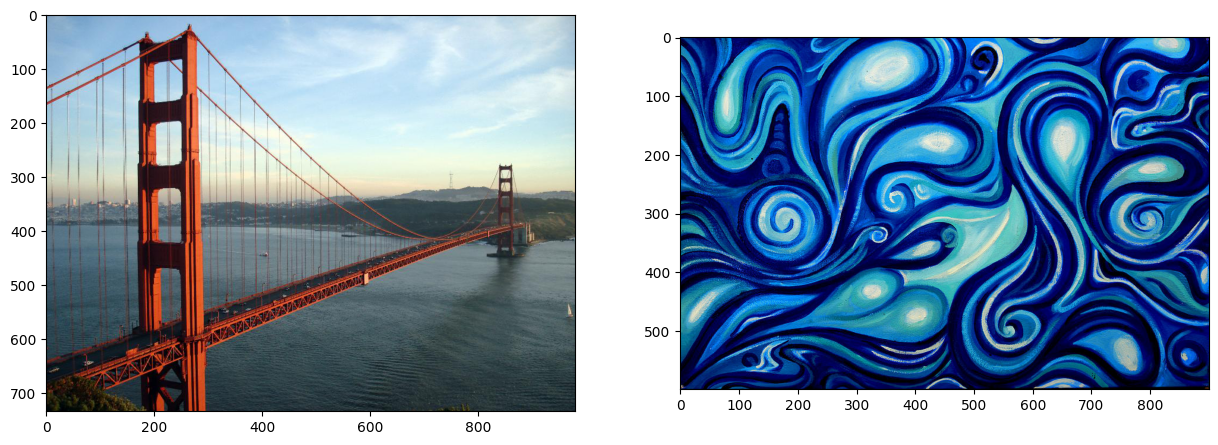

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# read the image file in a numpy array
a = plt.imread(base_image_path)
b = plt.imread(style_image_path)
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(a)
axarr[1].imshow(b)
plt.show()


In [6]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [7]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [8]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [ ]:
from tensorflow.keras.applications import vgg19
from keras.utils import plot_model

model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

In [10]:
from keras import Model

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [11]:
style_cnn = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_cnn = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensioner.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Get the values in all the layers for the three images.
    features = feature_extractor(input_tensor)

    #3. Inicializar the loss

    loss = tf.zeros(shape=())

    # 4. Extract the content layers + content loss
    layer_features = features[content_cnn]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # 5. Extraer the style layers + style loss
    for layer_name in style_cnn:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_cnn)) * sl

    return loss

In [12]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [13]:
import keras
from tensorflow.keras.applications import vgg19
from keras.utils import load_img, img_to_array
import numpy as np


def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img =load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [14]:
def deprocess_image(x):

    # Convert the tensor into Array
    x = x.reshape((img_nrows, img_ncols, 3))

    # We ensure that they do not have an average of 0
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # convert from BGR to RGB
    x = x[:, :, ::-1]

    # Ensure that they are between 0 and 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x

In [15]:
from datetime import datetime

def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(combination_image.numpy())
  keras.preprocessing.image.save_img(image_name, img)

In [16]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

In [17]:
from keras.optimizers import SGD

width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

optimizer = SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 2500

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 10: loss=67188.59
Iteration 20: loss=39788.21
Iteration 30: loss=29622.05
Iteration 40: loss=24854.43
Iteration 50: loss=17441.46
Iteration 60: loss=13749.35
Iteration 70: loss=12458.44
Iteration 80: loss=11841.39
Iteration 90: loss=11400.36
Iteration 100: loss=10113.70
Iteration 110: loss=9517.38
Iteration 120: loss=8789.28
Iteration 130: loss=8221.85
Iteration 140: loss=7935.30
Iteration 150: loss=7753.36
Iteration 160: loss=8258.78
Iteration 170: loss=7041.06
Iteration 180: loss=7086.79
Iteration 190: loss=6524.23
Iteration 200: loss=6309.43
Iteration 210: loss=6309.93
Iteration 220: loss=6102.81
Iteration 230: loss=5818.10
Iteration 240: loss=5922.33
Iteration 250: loss=5667.49
Iteration 260: loss=5464.47
Iteration 270: loss=5265.05
Iteration 280: loss=5138.02
Iteration 290: loss=5274.32
Iteration 300: loss=5207.92
Iteration 310: loss=4823.96
Iteration 320: loss=4730.19
Iteration 330: loss=4647.07
Iteration 340: loss=4668.40
Iteration 350: loss=4582.16
Iteration 360: loss

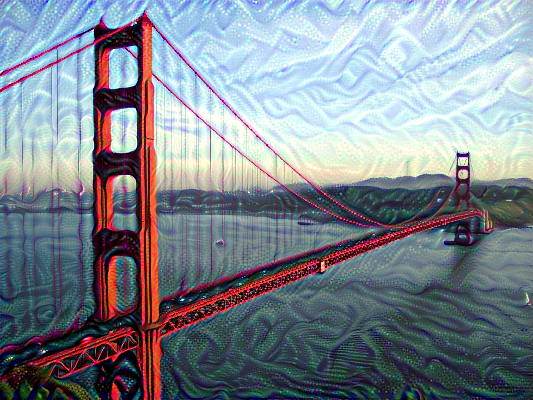

In [18]:
from IPython.display import Image
Image('/content/10_20230616_152036_image.png')

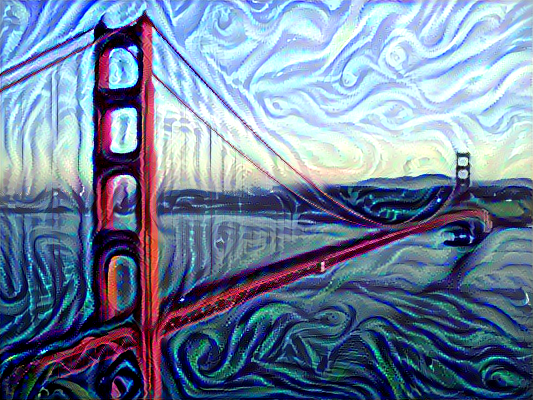

In [21]:
from IPython.display import Image
Image('/content/600_20230616_152301_image.png')

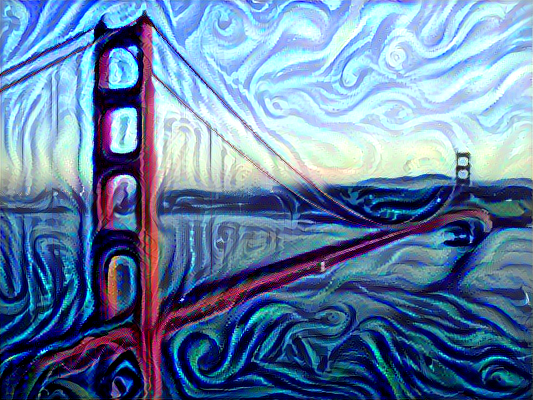

In [20]:
from IPython.display import Image
Image('/content/2500_20230616_153100_image.png')